In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange
from flygym import Simulation, Camera
from flygym.arena import FlatTerrain



In this example, we will simulate a fly chasing another fly based on vision. This is similar to the [visual taxis task in week 4](https://github.com/NeLy-EPFL/cobar-exercises/blob/main/week4/1_vision.ipynb), but the ball will be replaced by a walking fly.

For multi-fly simulation, we might want to control the flies differently and have different observation/action spaces for different flies. Therefore, we will inherit from `Fly` and implement different logic in the `pre_step` method. 

In [2]:
from hybrid_turning_fly import HybridTurningFly
from movodor_arena import MovOdorArena
from odor_turning_fly import OdorTaxisFly
from female_decision_hybri_turn_fly import FemaleDecisionHybriTurnFly


In [3]:
# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[4, 4, 4],[5, 5, 5]], dtype=np.float32)

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[0, 1],[1, 0]])
odor_threshold = 0.14
if peak_odor_intensity[0][0] == 0:
    odor_threshold = 0.057

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

# Gains for the two odors (negative = attractive, positive = aversive)
odor_gains = np.array([-100, 100])

In [4]:
timestep = 1e-4
decision_interval = 0.05
run_time = 1

fly0 = OdorTaxisFly(  # This is the "chasing" fly (aka male fly)
    name="male",
    odor_threshold = odor_threshold, # Threshold found empiricly
    odor_dimensions=odor_dimensions,
    odor_gains=odor_gains,
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(0, 0, 0),
)


fly1 = FemaleDecisionHybriTurnFly(  # This is the "chased" fly (aka female fly)
    name="female",
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(8, 0, 0),
    odor_threshold = [0.119, 0.03] # Threshold found empiricly
)


arena = MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    num_sensors=4,
    move_speed=0,
    move_direction="right",
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

# THIS IS THE CAMERA THAT WILL BE USED FOR FOLLOWING THE CENTER OF MASS OF THE FLY
mov_birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="mov_birdeye_cam",
    mode="fixed",
    pos=(15, 0, 40), # (15, 0, 40) the 40 is the camera height which is constant
    euler=(0, 0, 0),
    fovy=45,
)
#-------------------------------------------------------------------------------

cam = Camera(
    fly=fly1,
    camera_id="birdeye_cam", # This is not used as argument
    play_speed=0.5,
    window_size=(800, 608),
)

cam_male = Camera(
    fly=fly0,
    camera_id="Animat/camera_left",
    window_size=(800, 608),
    play_speed=0.5,
)


sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam, cam_male],
    arena=arena,
    timestep=timestep,
)

fly_names = [fly.name for fly in sim.flies]

[[0.02070131 0.01986565]
 [0.03074024 0.02928818]]


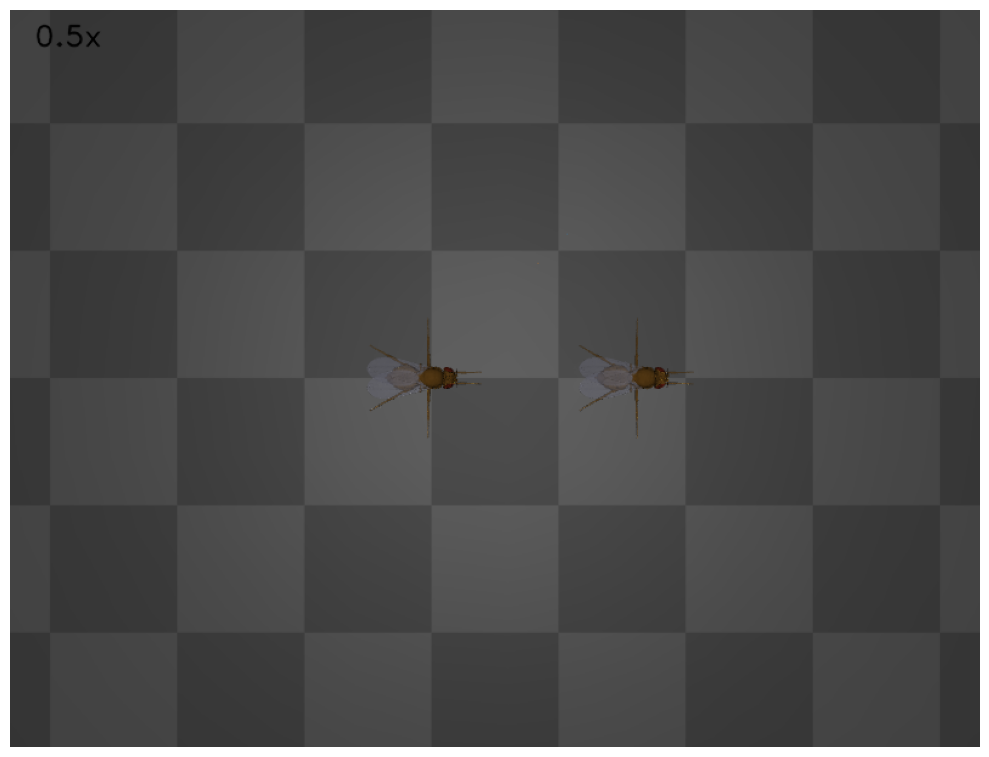

In [5]:
for i in range(2):
    obs, _, _, _, info = sim.step({
                                "male": np.zeros(2),
                                "female": np.zeros(2)
                                })
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")

odor = obs["male"]["odor_intensity"].reshape((odor_dimensions, 2, 2))
I = np.average(odor, axis=1, weights=[120, 1200])
# Calculate the left-right asymmetry in the odor intensities
I_l, I_r = I[:, 0], I[:, 1]
print(I)

threshold_male_attractive = 0.163  # threshold for the male to stop

threshold_male_aversive = 0.0983  # threshold for the male to stop


acceptance_threshold_male_attractive = 0.135 # threshold for the female to accept male (this is the attractive threshold)

acceptance_threshold_male_aversive = 0.038  # threshold for the female to reject male (this is the aversive threshold)

### Construction of controlling signals and P1

In [6]:
def p1_control_signal(run_time: float, time_step: float) -> np.ndarray:
    """Returns a P1 signal [0,1].
    The control signal is a 2D array of shape (num_time_steps, 2)"""
    
    # P1 signal is a 2D array of shape (num_time_steps, 2)
    p1_signal = np.ones((int(run_time / time_step), 1))
    
    # Create a sine wave signal 
    p1_signal[:, 0] = 0.5*(np.sin(1 * np.pi * np.linspace(0, run_time, int(run_time / time_step)))+1) 
    
    
    return p1_signal

def plot_signal(p1_signal, name: str):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
    ax.plot(p1_signal)
    ax.set_xlabel("Time steps")
    ax.set_ylabel(name)
    ax.set_title(name)

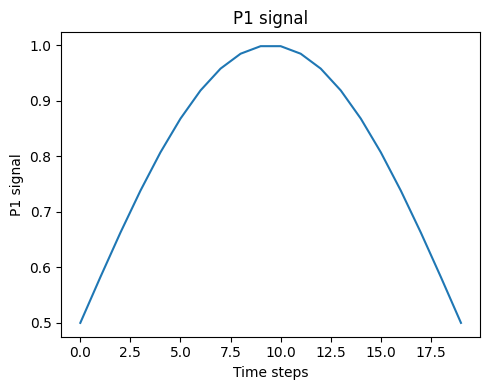

In [7]:
p1_signal = p1_control_signal(run_time, decision_interval)
plot_signal(p1_signal, "P1 signal")

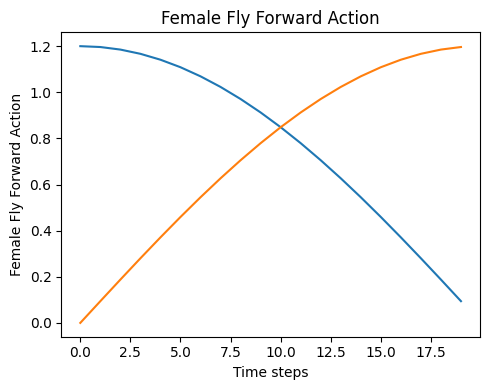

In [8]:
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / timestep)

t = np.arange(0, run_time, decision_interval)

fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

# # set the last 2s of the actions to 0
# fly1_actions[int((run_time-2) / decision_interval) :, :] = 0

# # Let the fly stop after 0.5 seconds for 1 seconds
# fly1_actions[int(0.5 / decision_interval) : int(1.5 / decision_interval), :] = 0

plot_signal(fly1_actions, "Female Fly Forward Action")

#### Run the simulation

In [9]:
from flygym.examples.common import PreprogrammedSteps

In [10]:
# # Changes the color of the fly to black
# for i in fly1.model.find_all("geom"):
#     sim.physics.named.model.geom_rgba[f"female/{i.name}"] = (0, 0, 0, 1)

# For the camera following the fly
second_cam_frames = []
x = None
y = None
alpha = 1e-1
render = True
# Initialize the control signal
control_signal = np.zeros(odor_dimensions)
obs_history = []
odor_source_hist = []

fly1.hybrid_turning = True
female_state = "no_fly_nearby"

obs, _ = sim.reset(seed=seed)
print("Part 1: chasing")
for i in trange(num_decision_steps):

    #**********************************************************************************
    female_state = fly1.get_female_mating_decision(odor_intensities=obs["female"]["odor_intensity"], timestep=decision_interval)
    if female_state == "reject" or female_state == "accept":
        break


    #**********************************************************************************

    control_signal = fly0.process_odor_intensities(obs["male"]["odor_intensity"])
    control_signal *= p1_signal[i]
    
    for j in range(physics_steps_per_decision_step):
        #********************************************************************************************************************
        if female_state == "reject":
            break
        elif female_state == "accept":
            break
        elif female_state == "fly_nearby" or female_state == "no_fly_nearby":
            obs, _, _, _, info = sim.step(
            {
                "male": control_signal,
                #"female": fly1_actions[i],
                "female": np.zeros(2),
            }
            )
        #********************************************************************************************************************
            
        #To bind the odor source position to a fly position
        for j, name in enumerate(fly_names):
            arena.odor_source[j] = obs[name]["fly"][0]

        if render:
            #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY -----------
            render_res = sim.render()[0]

            if render_res is not None:
                second_cam = sim.physics.bind(mov_birdeye_cam)

                x_new = obs["male"]["fly"][0][0]
                y_new = obs["male"]["fly"][0][1]

                if x is None:
                    x = x_new
                
                if y is None:
                    y = y_new

                x = (1 - alpha) * x + alpha * x_new
                y = (1 - alpha) * y + alpha * y_new

                second_cam.pos[0] = x
                second_cam.pos[1] = y

                second_img = sim.physics.render(
                    width=700, height=560, camera_id="mov_birdeye_cam"
                )
                second_img = cv2.putText(
                    np.ascontiguousarray(second_img),
                    f"{sim.cameras[0].play_speed}x",
                    org=(20, 30),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.8,
                    color=(0, 0, 0),
                    lineType=cv2.LINE_AA,
                    thickness=1,
                )
                second_cam_frames.append(second_img)
                #----------------------------------------------------------------------

        odor_source_hist.append(arena.odor_source.copy())
        obs_history.append(obs)

#**************************************************************************************
fly0.odor_turning = False
fly1.hybrid_turning = False
fly1.hybrid_turning = True # FOR testing

preprogrammed_steps=PreprogrammedSteps()
swing_periods = preprogrammed_steps.swing_period
legs = preprogrammed_steps.legs

run_time = 0.5
target_num_steps = int(run_time // sim.timestep)

foreleg_ids = np.zeros(target_num_steps)
middle_stance_ids = np.linspace(swing_periods["RM"][1], 2 * np.pi, target_num_steps)
hind_swing_ids = np.linspace(0.0, swing_periods["RH"][1], target_num_steps)

R_midleg_start = preprogrammed_steps.get_joint_angles("RM", swing_periods["RM"][1])
R_midleg_stretch = np.linspace(
    np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps
)

L_midleg_start = preprogrammed_steps.get_joint_angles("LM", swing_periods["LM"][1])
L_midleg_stretch = np.linspace(
    np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps
)

adhesion_action = np.array([0.0 if leg.endswith("F") else 1.0 for leg in legs])

all_joint_angles = []
print(female_state)
if female_state == "no_fly_nearby" or female_state == "fly_nearby":
    female_state = fly1.get_female_mating_decision(obs["female"]["odor_intensity"], timestep=1, time_before_decision=0)
print(female_state)
female_state = "no_fly_nearby" # THIS IS FOR TESTING


print("Part 2: preprogrammed steps, female reaction")
for i in trange(target_num_steps):

    # For the male fly's action
    joint_angles = []
    for leg in legs:
        if leg.endswith("F"):
            joint_angles.extend(
                preprogrammed_steps.get_joint_angles(leg, foreleg_ids[i])
            )
        elif leg.endswith("M"):
            midleg_joint_angles = preprogrammed_steps.get_joint_angles(
                leg, middle_stance_ids[i]
            )
            if leg.startswith("R"):
                midleg_joint_angles += R_midleg_stretch[i]
            elif leg.startswith("L"):
                midleg_joint_angles += L_midleg_stretch[i]

            joint_angles.extend(midleg_joint_angles)
        else:
            joint_angles.extend(
                preprogrammed_steps.get_joint_angles(leg, hind_swing_ids[i])
            )

    all_joint_angles.append(joint_angles.copy())

    male_action = {"joints": np.array(joint_angles), "adhesion": adhesion_action}

    # For the female fly's action
    female_action = 0
    if female_state == "accept":
        ...
        female_action = {"joints": np.array(joint_angles), "adhesion": adhesion_action}

    elif female_state == "reject":
        ... 
        female_action = {"joints": np.array(joint_angles), "adhesion": adhesion_action}

    else:
        fly1.hybrid_turning = True
        female_action = np.zeros(2)

    
    obs, _, _, _, info = sim.step(
    {
        "male": male_action,
        "female": female_action,
    }
    )
    
    if render:
        #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY ------------------------------------------------
        render_res = sim.render()[0]

        if render_res is not None:
            second_cam = sim.physics.bind(mov_birdeye_cam)

            x_new = obs["male"]["fly"][0][0]
            y_new = obs["male"]["fly"][0][1]

            if x is None:
                x = x_new
            
            if y is None:
                y = y_new

            x = (1 - alpha) * x + alpha * x_new
            y = (1 - alpha) * y + alpha * y_new

            second_cam.pos[0] = x
            second_cam.pos[1] = y

            second_img = sim.physics.render(
                width=700, height=560, camera_id="mov_birdeye_cam"
            )
            second_img = cv2.putText(
                np.ascontiguousarray(second_img),
                f"{sim.cameras[0].play_speed}x",
                org=(20, 30),
                fontFace=cv2.FONT_HERSHEY_DUPLEX,
                fontScale=0.8,
                color=(0, 0, 0),
                lineType=cv2.LINE_AA,
                thickness=1,
            )
            second_cam_frames.append(second_img)
            #------------------------------------------------------------------------------------------------

    odor_source_hist.append(arena.odor_source.copy())
    obs_history.append(obs)



Part 1: chasing


  0%|          | 0/20 [00:00<?, ?it/s]

[0.02020118 0.0201905 ]


  5%|▌         | 1/20 [00:24<07:46, 24.53s/it]

[0.09683167 0.01131123]


 10%|█         | 2/20 [00:49<07:24, 24.70s/it]

[0.09594297 0.01204078]


 15%|█▌        | 3/20 [01:13<06:54, 24.36s/it]

[0.09575234 0.0129018 ]


 20%|██        | 4/20 [01:37<06:31, 24.46s/it]

[0.09506197 0.014296  ]


 25%|██▌       | 5/20 [02:02<06:09, 24.63s/it]

[0.09440178 0.01594277]


 30%|███       | 6/20 [02:27<05:46, 24.72s/it]

[0.0941885  0.01827049]


 35%|███▌      | 7/20 [02:52<05:21, 24.74s/it]

[0.09360394 0.02144433]


 40%|████      | 8/20 [03:14<04:48, 24.02s/it]

[0.0936456  0.02558241]


 45%|████▌     | 9/20 [03:36<04:16, 23.34s/it]

[0.09309634 0.03031162]


 50%|█████     | 10/20 [04:01<03:56, 23.69s/it]

[0.09294276 0.0370729 ]
Fly is close to the odor source, stopping the fly


 55%|█████▌    | 11/20 [04:26<03:37, 24.16s/it]

[0.09264822 0.03215125]


 60%|██████    | 12/20 [04:51<03:14, 24.33s/it]

[0.09219591 0.03225022]


 65%|██████▌   | 13/20 [05:15<02:50, 24.39s/it]

[0.09221562 0.03228926]


 70%|███████   | 14/20 [05:36<02:20, 23.35s/it]

[0.09192601 0.03239893]


 75%|███████▌  | 15/20 [05:57<01:53, 22.61s/it]

[0.09159965 0.0324274 ]


 80%|████████  | 16/20 [06:19<01:29, 22.27s/it]

[0.09154228 0.03236221]


 85%|████████▌ | 17/20 [06:39<01:05, 21.82s/it]

[0.09111744 0.03246615]


 90%|█████████ | 18/20 [07:00<00:43, 21.55s/it]

[0.09121676 0.03234273]


 95%|█████████▌| 19/20 [07:21<00:21, 21.44s/it]

[0.09094242 0.03231532]


100%|██████████| 20/20 [07:42<00:00, 23.14s/it]


fly_nearby
[0.09067779 0.0323288 ]
reject
Part 2: preprogrammed steps, female reaction


 47%|████▋     | 2354/4999 [01:41<01:59, 22.16it/s]

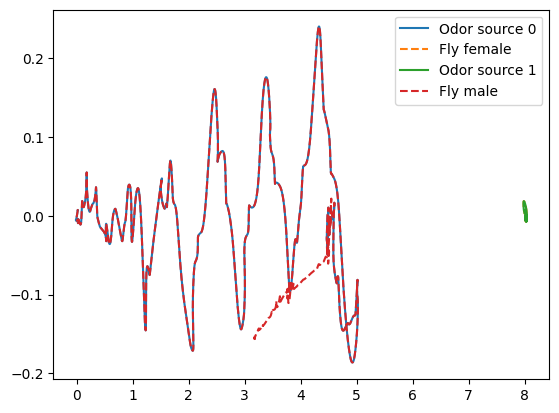

In [19]:
# plot the odor source trajectory vs fly trajectory
import matplotlib.pyplot as plt
fly_pos_hist_1 = np.array([obs["female"]["fly"][0, :2] for obs in obs_history])
fly_pos_hist_0 = np.array([obs["male"]["fly"][0, :2] for obs in obs_history])
odor_source_hist = np.array(odor_source_hist)
plt.plot(odor_source_hist[:,0,0], odor_source_hist[:,0,1], label="Odor source 0")
plt.plot(fly_pos_hist_1[:,0], fly_pos_hist_1[:,1], label="Fly female", linestyle="--")
plt.plot(odor_source_hist[:,1,0], odor_source_hist[:,1,1], label="Odor source 1")
plt.plot(fly_pos_hist_0[:,0], fly_pos_hist_0[:,1], label="Fly male", linestyle="--")
plt.legend()
plt.show()

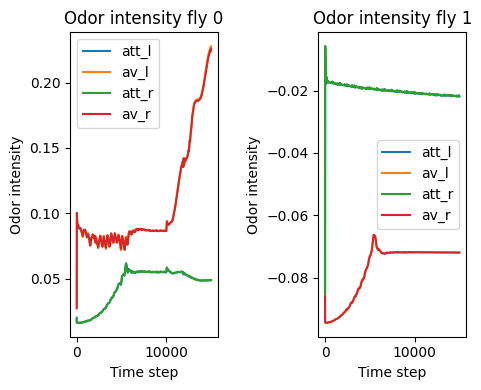

In [20]:
#plot histroy of observations odors intensities
odor_history_fly0 = [np.average(obs_history[i]["male"]["odor_intensity"].reshape((odor_dimensions, 2, 2)), axis=1) for i in range(len(obs_history))]
odor_l_history = [odor_history_fly0[i][:, 0] for i in range(len(odor_history_fly0))]
odor_r_history = [odor_history_fly0[i][:, 1] for i in range(len(odor_history_fly0))]

odor_history_fly1 = [np.average(obs_history[i]["female"]["odor_intensity"].reshape((odor_dimensions, 2, 2)), axis=1) for i in range(len(obs_history))]
odor_l_history_fly1 = [odor_history_fly1[i][:, 0] for i in range(len(odor_history_fly1))]
odor_r_history_fly1 = [odor_history_fly1[i][:, 1] for i in range(len(odor_history_fly1))]

plot_odor_l = np.array(odor_l_history)
plot_odor_r = np.array(odor_r_history)
fig, ax = plt.subplots(1, 2, figsize=(5, 4), tight_layout=True)
ax[0].title.set_text("Odor intensity fly 0")
ax[0].plot(plot_odor_l, label=["att_l", "av_l"])
ax[0].plot(plot_odor_r, label=["att_r", "av_r"])
ax[0].set_xlabel("Time step")
ax[0].set_ylabel("Odor intensity")
ax[0].legend()

plot_odor_l = np.array(odor_l_history_fly1) - 0.1058
plot_odor_r = np.array(odor_r_history_fly1) - 0.1058
ax[1].title.set_text("Odor intensity fly 1")
ax[1].plot(plot_odor_l, label=["att_l", "av_l"])
ax[1].plot(plot_odor_r, label=["att_r", "av_r"])
ax[1].set_xlabel("Time step")
ax[1].set_ylabel("Odor intensity")
ax[1].legend()

plt.show()

In [21]:
#birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
cam.save_video("video_chasing/chasing_lunging_2.mp4")

In [22]:
from IPython.display import Video

Video("video_chasing/chasing_lunging_2.mp4", width=800, height=608)

In [15]:
cam_male.save_video("video_chasing/chasing_lunging_side_camera.mp4")

In [18]:
Video("video_chasing/chasing_lunging_side_camera.mp4", width=800, height=608)